# Region simulation tutorial


A basic simulation consists of five main components, each of these components is an object within TVB:

- Model, which is, at its core, a set of differential equations describing the local neuronal dynamics;
- Connectivity, represents the large scale structural connectivity of the brain, ie white-matter tracts;
- Coupling, is a function that is used to join the local Model dynamics at distinct locations over the connections described in Connectivity;
- Integrator, is the integration scheme that will be applied to the coupled set of differential equations;
- Monitors, one or more Monitors can be attached to a simulation, they act to record the output from the Simulator.

All of these components are brought together in a Simulator object, which is then used to run a simulation.

Sketched from: https://github.com/the-virtual-brain/tvb-root/blob/master/tvb_documentation/tutorials/tutorial_s1_region_simulation.ipynb

For others tutorials: https://github.com/the-virtual-brain/tvb-root/tree/master/tvb_documentation/tutorials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tvb.simulator.lab import *
"""
 pip install tvb-library
 pip install tvb-framework
 https://github.com/the-virtual-brain/tvb-root/tree/master
"""

'\n pip install tvb-library\n pip install tvb-framework\n https://github.com/the-virtual-brain/tvb-root/tree/master\n'

## model

In [2]:
oscillator = models.Generic2dOscillator()
#oscillator = models.JansenRit() # have a look to notebook JensenRit_et_al_1995 in brian2 folder

# models.Hopfield
# models.Generic2dOscillator()

# note for JensenRit

https://github.com/the-virtual-brain/tvb-root/blob/master/tvb_library/tvb/simulator/models/jansen_rit.py

class JansenRit(ModelNumbaDfun):
    r"""
    The Jansen and Rit is a biologically inspired mathematical framework
    originally conceived to simulate the spontaneous electrical activity of
    neuronal assemblies, with a particular focus on alpha activity, for instance,
    as measured by EEG. Later on, it was discovered that in addition to alpha
    activity, this model was also able to simulate evoked potentials.

    .. [JR_1995]  Jansen, B., H. and Rit V., G., *Electroencephalogram and
        visual evoked potential generation in a mathematical model of
        coupled cortical columns*, Biological Cybernetics (73) 357:366, 1995.

    .. [J_1993] Jansen, B., Zouridakis, G. and Brandt, M., *A
        neurophysiologically-based mathematical model of flash visual evoked
        potentials*

    .. figure :: img/JansenRit_45_mode_0_pplane.svg
        :alt: Jansen and Rit phase plane (y4, y5)

        The (:math:`y_4`, :math:`y_5`) phase-plane for the Jansen and Rit model.

    The dynamic equations were taken from [JR_1995]_

    .. math::
        \dot{y_0} &= y_3 \\
        \dot{y_3} &= A a\,S[y_1 - y_2] - 2a\,y_3 - a^2\, y_0 \\
        \dot{y_1} &= y_4\\
        \dot{y_4} &= A a \,[p(t) + \alpha_2 J + S[\alpha_1 J\,y_0]+ c_0]
                    -2a\,y - a^2\,y_1 \\
        \dot{y_2} &= y_5 \\
        \dot{y_5} &= B b (\alpha_4 J\, S[\alpha_3 J \,y_0]) - 2 b\, y_5
                    - b^2\,y_2 \\
        S[v] &= \frac{2\, \nu_{max}}{1 + \exp^{r(v_0 - v)}}

    """

## connectivity

In [3]:
conn = connectivity.Connectivity.from_file()

# conn.speed = np.array([4.0])

2024-05-01 16:47:55,789 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


## coupling

In [4]:
conn_coupling = coupling.Linear(a=np.array([0.0154]))

## thalamic stimulation

In [5]:
do_stim=True
if do_stim:
    conn.configure()
    nodes = [10, 50] # e.g., [35, 36] # V1 and V2 
    stim_weights = np.zeros((conn.number_of_regions, 1))
    k = .1
    stim_weights[nodes] = np.array([1*k, 0.0])[:, np.newaxis] # il weight of roi50 is set to 0
    eqn_t = equations.PulseTrain()
    eqn_t.parameters["onset"] = 100.0 # ms
    eqn_t.parameters["tau"]   = 1 # 5 ms
    eqn_t.parameters["T"]     = 1*k # 500 -> 0.002kHz repetition frequency

    stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                      connectivity = conn, 
                                      weight = stim_weights)
else:
    stimulus = None

## integrator

In [6]:
h = 1 #ms
heunint = integrators.HeunDeterministic(dt=h) #, noise=noise.Additive(nsig = numpy.array([0.015]))


## monitors

In [7]:
#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=h*50)

#Bundle them
recordings = (mon_raw, mon_tavg)

#monitors.Raw()
#monitors.MEG()
#monitors.Bold()
#monitors.EEG(projection=projections.ProjectionSurfaceEEG.from_file(), 
#             sensors=sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt"), 
#             region_mapping=region_mapping.RegionMapping.from_file(), 
#             period=1e3/2048.))


## simulator

In [8]:
#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = conn,
                          coupling = conn_coupling, 
                          integrator = heunint, 
                          stimulus = stimulus,
                          monitors = recordings)

sim.configure()

## run 

In [9]:
#Perform the simulation

raw_data = []
raw_time = []
tavg_data = []
tavg_time = []
k = 10
bioTime = 250*k #ms
for raw, tavg in sim(simulation_length=bioTime):
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

2024-05-01 16:47:56,064 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


## results

In [10]:
#Make the lists numpy.arrays for easier use.
RAW = np.array(raw_data)
TAVG = np.array(tavg_data)

Text(0.5, 1.0, 'Temporal average')

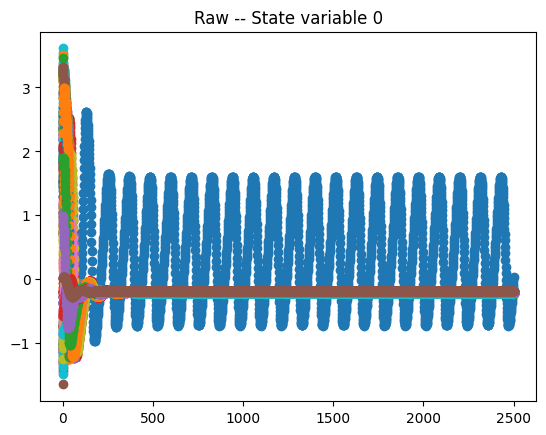

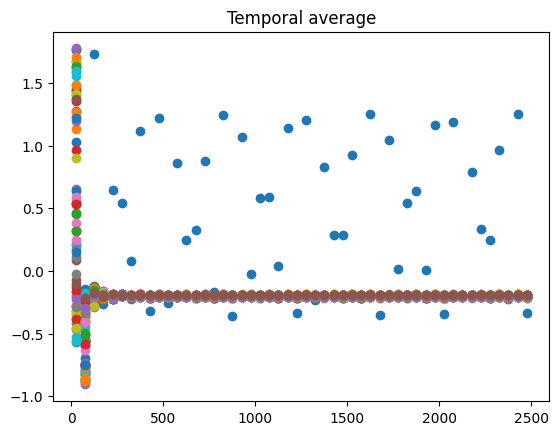

In [11]:
#Plot raw time series
plt.figure(1)
plt.plot(raw_time, RAW[:, 0, :, 0], 'o')
plt.title("Raw -- State variable 0")

#Plot temporally averaged time series
plt.figure(2)
plt.plot(tavg_time, TAVG[:, 0, :, 0], 'o')
plt.title("Temporal average")


In [12]:
RAW.squeeze().shape

(2500, 76)

<Axes: >

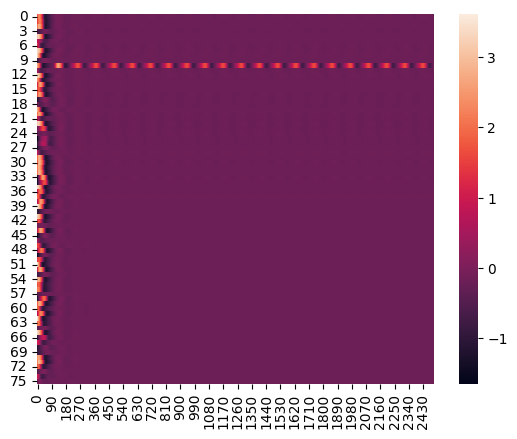

In [14]:
sns.heatmap(RAW.squeeze().T)